# Машинное обучение, DS-поток, осень 2022
# Задание 3.6. Random Forest

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LinearRegression
import scipy.stats as sps


warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)

## Задача 1

Запишите оценку сложности построения одного решающего дерева в зависимости от размера обучающей выборки $n$, числа признаков $d$, максимальной глубины дерева $D$. В качестве правил используются пороговые функции $I\{x_j>t\}$. При выборе правил в каждой вершине перебираются все признаки, а в качестве порогов рассматриваются величины $t$, равные значениям этого признака на объектах, попавших в текущую вершину. Для простоты, считайте сложность вычисления критерия информативности по уже построенному множеству объектов константной.

## Задача 2

Пусть обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$ такова, что
* объекты $X_1, ..., X_n$ одномерны и имеют распределение $\mathcal{N}(0, \sigma^2)$;
* отклик получается по правилу $Y_i = X_i^2 + \varepsilon_i$, где $\varepsilon_i$ независимы, имеют нулевое среднее и не зависят от $X_i$. 

Пусть также для объекта $X$ отклик $Y$ получен по аналогичному правилу, причем $X$ и $Y$ не зависят от обучающей выборки.

Для МНК-модели $\widehat{y}(x) = \widehat{\theta} x$ выпишите подробное bias-variance разложение со всеми тремя компонентами: смещение, разброс, шум. Компоненту, отвечающую за разброс, разрешается не доводить до конца. Если в выражении присутствует дисперсия $\varepsilon_i$, то так и пишите: $D(\varepsilon_i)$.

## Задача 3

В этой задаче вам предлагается исследовать зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмём датасет `california_housing` из библиотеки `sklearn` о стоимости недвижимости в различных округах Калифорнии. Этот датасет состоит из 20640 записей и содержит следующие признаки для каждого округа: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`. `HouseAge` и `Population` &mdash; целочисленные признаки. Остальные признаки &mdash; вещественные.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

In [183]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разбейте данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1)

### *Дорешка*
*Ошибка - неправильно разбивала train и validation*

In [185]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1) # 0.85*0.3 = 0.25

Посмотрите, как изменяется качество леса в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25). Когда варьируете один из параметров, в качестве другого берите значение по умолчанию.

Попробуйте получить зависимость от количества деревьев, обучив лишь один случайный лес. В этом вам поможет аттрибут `_estimators` у обученной модели.

In [165]:
md_grid = np.arange(3, 26)
mses = []

for md in md_grid:
    m = RandomForestRegressor(max_depth=md)
    m.fit(X_train, y_train)
    mse = mean_squared_error(y_test, m.predict(X_test))
    mses.append(mse)

mses = np.array(mses)

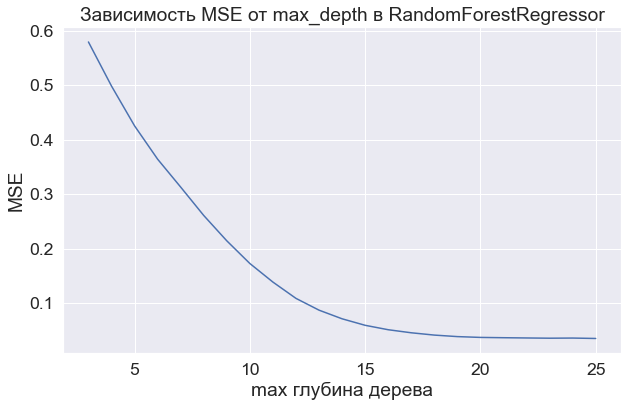

In [176]:
plt.figure(figsize=(10, 6))
plt.plot(md_grid, mses)
plt.xlabel('max глубина дерева')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_depth в RandomForestRegressor');

*Обучим случайный лес со 100 деревьями и получим зависимость используя кумулятивную сумму:*

In [167]:
m = RandomForestRegressor(n_estimators=500)
m.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [168]:
predictions_by_estimators = [est.predict(X_test) for est in m.estimators_]

In [169]:
numerator = np.array(predictions_by_estimators).cumsum(axis=0)
n = len(predictions_by_estimators)
denominator = (np.arange(n) + 1)[:, np.newaxis]
cumpred = numerator / denominator
    
cumacc = [mean_squared_error(y_test, pred) for pred in cumpred]

In [172]:
nestimators_grid = range(1, 501)

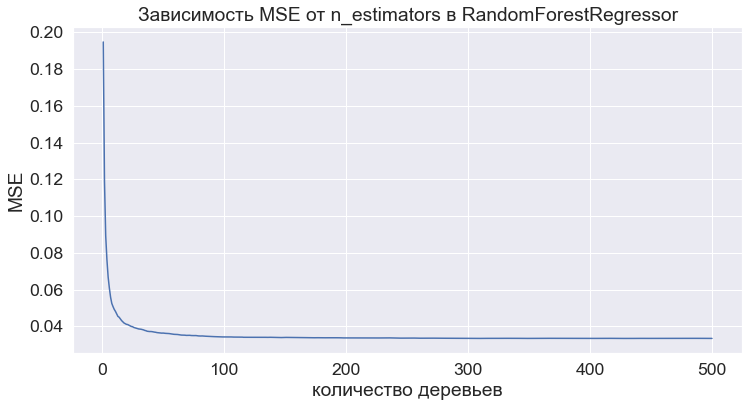

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(nestimators_grid, cumacc)
plt.xlabel('количество деревьев')
plt.ylabel('MSE')
plt.title('Зависимость MSE от n_estimators в RandomForestRegressor');

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для случайного леса? Поясните свой ответ, опираясь на своё знание статистики.

### *Дорешка*
**Ответ:** 
*1-2. В обоих случаях MSE сначала резко падает, затем выходит на плато. Падение ожидаемо - чем больше листьев и количество эстиматоров, тем должна быть меньше ошибка, так как увеличивается количество листьев и результат все лучше усредняется соответственно. Однако, при достижении достаточно больших значений этих гиперпараметров качество почти не улучшается. Это объясняется тем, что в данном случае деревья имеют определенную степень корреляции, особенно потому, что моя модель использовала дефолтное значение `max_features = 1.0`, то есть в каждом дереве для подбора оптимального сплита перебирались все признаки, а значит могли получаться деревья, у которых очень похожие предсказания. То есть по сути это не случайный лес, а бэггинг деревьев. Если же деревья полностью не коррелированы, то дисперсия предсказания монотонно снижается, а точность монотонно повышается. Поэтому, если брать идеальный случайный лес с некоррелированными деревьями, такая ситуация повторяться не должна.*

*3. Переобучение происходит, когда у модели низний bias, но высокий variance. Глядя на формулу для variance ансамбля, которую вывели на лекции:*
$$\mathrm{variance} = \mathsf{D} \widehat{y}_1(x) \left[ \frac{1}{T} + \frac{T-1}{T} \mathrm{corr} \left( \widehat{y}_1(x), \widehat{y}_2(x) \right) \right],$$
где 
* $y = f(x)$ — средняя ожидаемая зависимость,
* $T$ — количество деревьев в композиции.

*видим, что зависимости от глубины одного дерева нет, все решает количество деревьев - чем больше, тем ниже variance.* ***Однако на семинаре рассматривали пример, при котором при фиксированном количестве деревьев с увеличением максимальной глубины ошибка на тесте растет, а на трейне падает, что является признаком переобучения. Поэтому оно возможно, но случайный лес намного менее склонен к этому.***

Обучите случайный лес с параметрами по умолчанию и выведите MSE на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты отличаются? Какие источники случайности есть при построении случайного леса и какие из них реализуются в данном случае?

In [177]:
for i in range(3):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(f'MSE = {mean_squared_error(y_test, model.predict(X_test))}')


MSE = 0.03488683630920241
MSE = 0.035553481735689396
MSE = 0.03492840632998933


### *Дорешка*

**Ответ:** *В общем случае, случайность при построении возникает из-за 1) случайных выборок с возвращением и 2) выделения подмножества признаков для поиска оптимального разбиения в каждой вершине, которое задается параметром `max_features`. В случае бэггинга деревьев случайность, то есть модели по умолчанию, случайность обусловлена только 1) пунктом. Поэтому MSE немного отличаются.*

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

### *Дорешка*


In [195]:
gridsearch = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions={
        'max_depth': [None] + np.arange(3, 25).tolist(),
        'n_estimators': np.arange(1, 300), 

    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=0
)

gridsearch.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24],
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  5...
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 2

In [196]:
results_gs = pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')
results_gs.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,10.700279,1.537357,0.131511,0.014612,194,21,"{'n_estimators': 194, 'max_depth': 21}",-0.267676,-0.249591,-0.264465,-0.295299,-0.261066,-0.267619,0.015127,1
6,8.946341,0.297170,0.116828,0.011076,147,21,"{'n_estimators': 147, 'max_depth': 21}",-0.268073,-0.250236,-0.265219,-0.297339,-0.261185,-0.268410,0.015682,2
4,8.390618,0.160018,0.111105,0.017566,148,18,"{'n_estimators': 148, 'max_depth': 18}",-0.268741,-0.249482,-0.265903,-0.296407,-0.261752,-0.268457,0.015446,3
8,11.060477,0.419722,0.124948,0.005152,188,16,"{'n_estimators': 188, 'max_depth': 16}",-0.269494,-0.249867,-0.265372,-0.297532,-0.260839,-0.268621,0.015871,4
5,4.213199,0.051845,0.047541,0.004160,76,18,"{'n_estimators': 76, 'max_depth': 18}",-0.270528,-0.250167,-0.266724,-0.299270,-0.266437,-0.270625,0.015949,5


Выведите найденные оптимальные параметры.

In [197]:
gridsearch.best_estimator_

RandomForestRegressor(max_depth=21, n_estimators=194, random_state=42)

Зафиксируем эти оптимальные значения параметров и в дальнейшим будем их использовать.

In [198]:
max_depth = 21
n_estimators = 194

In [199]:
best_model = gridsearch.best_estimator_

Оценим качество предсказаний обученного решающего леса.

In [200]:
pred = best_model.predict(X_test)
print(f'Best model MSE {mean_squared_error(pred, y_test)}')

Best model MSE 0.26458407653838395


Исследуйте зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

In [201]:
max_features_range = np.arange(1, 9)
mses_train = []
mses_test = []


for mf in max_features_range:
    m = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, max_features=mf)
    m.fit(X_train, y_train)
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

Постройте график зависимости метрики mse на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

### *Дорешка*
*График был неверный из-за неправильного разделения выборок*

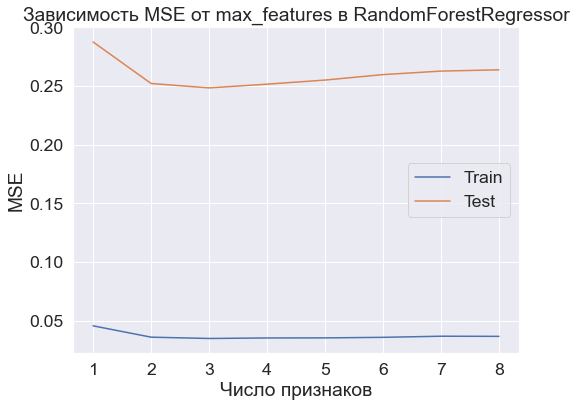

In [202]:
plt.figure(figsize=(8, 6))

plt.plot(max_features_range, mses_train, label='Train')
plt.plot(max_features_range, mses_test, label='Test')
plt.xlabel('Число признаков')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_features в RandomForestRegressor')
plt.legend();

Почему график получился таким? Как зависит разнообразие деревьев от величины `n_features`?

**Ответ:** *Если `max_features = n_features`, то каждое дерево использует все признаки для определения сплита. Соответственно, если `max_features = k < n_features`, то каждое дерево для каждого сплита будет использовать подвыборку из `k` случайных признаков. По графику видно, что для этих данных есть оптимальное число признаков - 3, при котором ошибка наименьшая. При уменьшении значения `max_features` увеличивается bias, так как важные признаки попадают в модель с меньшей вероятностью. Но практика показывает, что леса из менее точных и менее коррелированных деревьев работают лучше, чем леса из более точных и более коррелированных деревьев.*

Проведите эксперимент, в котором выясните, как изменится качество регрессии, если набор признаков, по которым происходит разбиение в каждой вершине определяется не заново в каждой вершине, а задан заранее для всего дерева. То есть перед каждым построением дерева выбирается новый набор признаков, который будет рассматриваться при построении всех разбиений в этом дереве.

Для реализации данного эксперимента используйте класс беггинг-модели `sklearn.ensemble.BaggingRegressor`, у которого используйте следующие поля:
* `base_estimator` — базовая модель, используйте `sklearn.tree.DecisionTreeRegressor`;
* `max_features` — количество признаков для каждой базовой модели;
* `n_estimators` — количество базовых моделей.

Постройте графики `mse` на обучающей и на валидационной выборке в зависимости от числа рассматриваемых признаков в дереве.

### *Дорешка*

In [213]:
mses_train = []
mses_valid = []

mses_train_rf = []
mses_valid_rf = []

for mf in max_features_range:
    bagging = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=max_depth),
        random_state=42,
        max_features=mf,
        n_estimators=n_estimators
    )
    bagging.fit(X_train, y_train)
    mses_train.append(mean_squared_error(y_train, bagging.predict(X_train)))
    mses_valid.append(mean_squared_error(y_val, bagging.predict(X_val)))
    
    m = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, max_features=mf)
    m.fit(X_train, y_train)
    mses_train_rf.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_valid_rf.append(mean_squared_error(y_val, m.predict(X_val)))

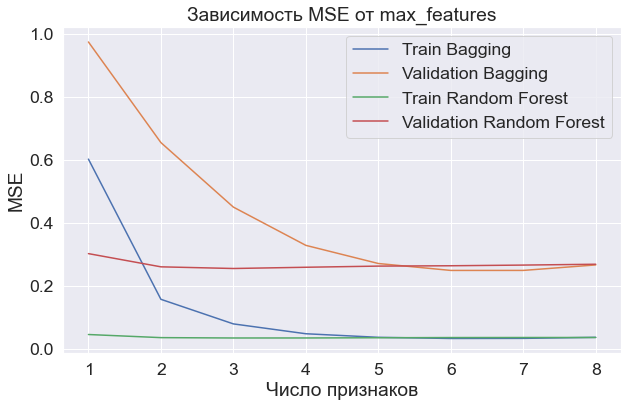

In [220]:
plt.figure(figsize=(10, 6))

plt.plot(max_features_range, mses_train, label='Train Bagging')
plt.plot(max_features_range, mses_valid, label='Validation Bagging')
plt.plot(max_features_range, mses_train_rf, label='Train Random Forest')
plt.plot(max_features_range, mses_valid_rf, label='Validation Random Forest')

plt.xlabel('Число признаков')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_features')
plt.legend();

Сравните результаты обычного случайного леса с только что построенным лесом.

Сделайте выводы. Объясните, чем плох такой подход пострения случайного леса. Какое преимущество мы получаем, когда выбираем случайное подмножество признаков в каждой вершине в обычном случайном лесу? Опирайтесь в своих рассуждениях на bias-variance разложение.

**Вывод.**
*Если в результате случайного леса нашлось оптимальное max_features, меньшее чем общее количество признаков, то в случае бэггинга ошибка падает с ростом max_features, за счет понижения bias, так как деревья учатся на всё более полном наборе признаков. Также в случае случайного леса MSE в целом ниже. Второй подход дает меньшее качество, потому что в таком лесу меньше случайности, так как набор признаков один для всех сплитов дерева, когда в случайном лесу набор случайный перед __каждым__ сплитом. Это значит, что в бэггинше деревья более коррелированы, а значит variance будет выше => MSE выше.*

Поясните разницу между следующими конструкциями:

`BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=n_features)`

`BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=n_features))`

*1 - Перед каждым построением дерева выбирается новый порядрок признаков, который будет рассматриваться при построении всех сплитов в этом дереве.*

*2 - Новый порядок признаков выбирается перед каждым сплитом, как в случайном лесу*

## Задача 4

На лекции получена формула bias-variance разложения для беггинга. Проведите эксперимент, в котором выясните, насколько уменьшается разброс (variance-компонента) беггинг-модели на 100 базовых моделях по отношению к одной базовой модели. Используйте данные из предыдущей задачи. Рассмотрите беггинг на следующих базовых моделях:
* решающие деревья, можно использовать вариант случайного леса,
* ридж-регрессия.

Для решения задачи потребуется оценить корреляции предсказаний на тестовой выборке базовых моделей, входящих в состав беггинг-модели. Их можно получить с помощью поля `estimators_` у обученной беггинг-модели. Для оценки корреляций используйте [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) или [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html).

Насколько уменьшается разброс в каждом случае? Для каждого случая постройте также матрицу корреляций предсказаний базовых моделей и гистограмму по ним.

In [222]:
ridge_bagging = BaggingRegressor(base_estimator=Ridge(), n_estimators=100, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

ridge_bagging.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [252]:
def print_correlations(model):
    predictions = [estimator.predict(X_test) for estimator in model.estimators_]
    estimators_count = len(model.estimators_)
    
    pearson_matrix = np.zeros((estimators_count, estimators_count))
    for i in range(estimators_count):
        for j in range(i, estimators_count):
            pearson_matrix[i, j] = sps.pearsonr(predictions[i], predictions[j])[0]
            pearson_matrix[j, i] = pearson_matrix[i, j]
    
    # визуализируем полученные матрицы ковариаций
    plt.figure(figsize=(15, 7))
    plt.subplot(121)
    ax = plt.gca()
    im = ax.imshow(pearson_matrix, interpolation='none')
    plt.colorbar(im, fraction=0.04, pad=0.04)
    plt.title(f'Корреляция Пирсона моделей {model}')
    plt.tight_layout()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(111)
    ravel_corr = pearson_matrix[np.tril_indices(100, k=-1)]
    plt.hist(ravel_corr, bins=30)
    plt.title('Пирсон: {:.3f} +- {:.3f}, моделей {}'.format(ravel_corr.mean(), ravel_corr.std(), model))
    plt.tight_layout()

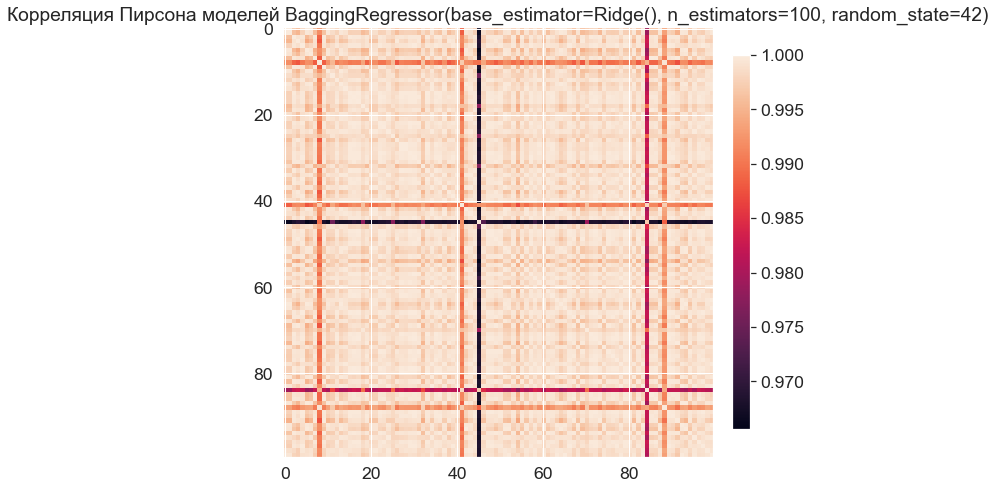

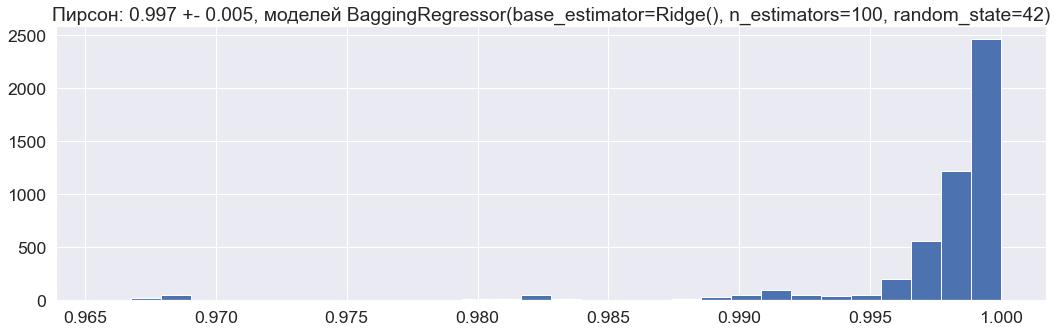

In [253]:
print_correlations(ridge_bagging)

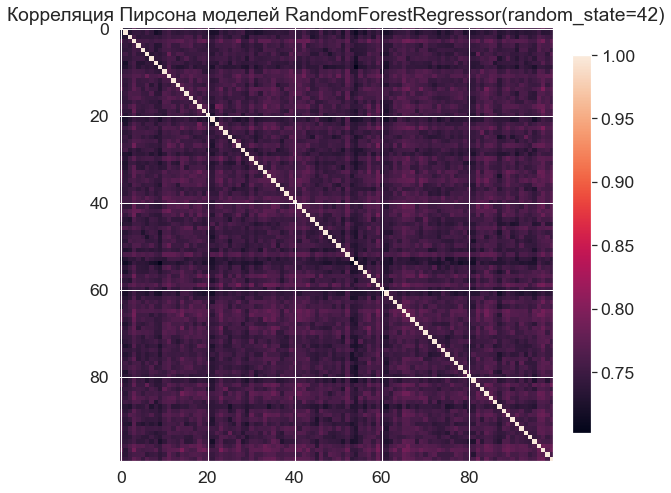

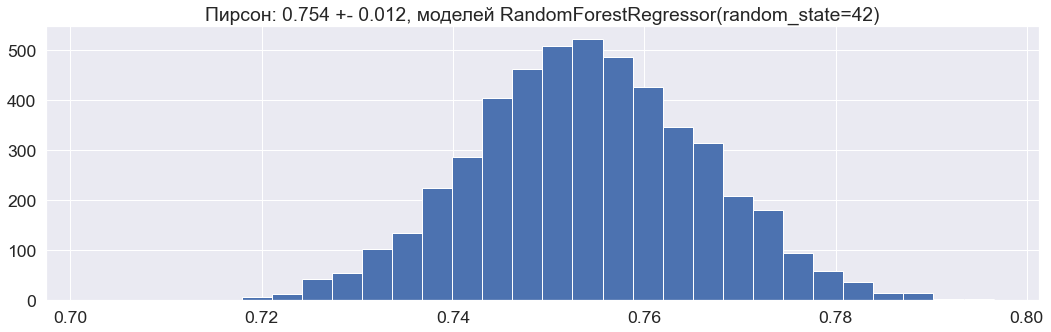

In [254]:
print_correlations(rf_regressor)

*Разбросы бэггинга и случаного леса:*

In [255]:
ridge_var = 1/100 + 99/100 * 0.998
rf_var = 1/100 + 99/100 * 0.77

In [256]:
ridge_var

0.99802

In [257]:
rf_var

0.7723

*Во сколько раз бэггинг уменьшил разброс предсказаний базовых моделей*

In [260]:
1 / ridge_var

1.001983928177792

In [261]:
1 / rf_var

1.2948336138806165

***Вывод***: 
*1) Ожидаемо, в случайном лесе базовые модели оказались менее коррелированными, чем в бэггинге ридж-регрессии, так как в лесе деревья разнообразнее чем модели рергесси в связи с бутстрепными выборками. 2) В обоих случаях разброс предсказаний уменьшился, и в случае случайного леса - сильнее.*